In [ ]:
import pandas as pd
import boto3
from botocore.config import Config
import json
from ast import literal_eval
import numpy as np
import pprint
pd.set_option("display.max_columns", 1000)
pd.options.display.max_rows = 10000

In [103]:
raw_df = pd.read_csv('/home/sanika/projects/iab_labelling/data/spiegel_mobile_crawled.csv', index_col= 0)

In [3]:
raw_df.shape

(999, 5)

In [4]:
raw_df.head()

referrer  \
0  http://m.spiegel.de/lebenundlernen/job/kulturs...   
1  http://m.spiegel.de/gesundheit/diagnose/quersc...   
2  http://m.spiegel.de/panorama/leute/royale-hoch...   
3  https://m.spiegel.de/politik/ausland/obama-us-...   
4  https://m.spiegel.de/kultur/literatur/stephen-...   

                                            keywords  \
0   ['Job & Karriere', 'Kulturschock', 'Usbekistan']   
1  ['Gesundheit', 'Diagnose & Therapie', 'Körperl...   
2  ['Panorama', 'Leute', 'Hochzeit von Prinz Harr...   
3  ['Ausland', 'NSA-Überwachung', 'Überwachung', ...   
4            ['Kultur', 'Literatur', 'Stephen King']   

                                               title  \
0  Kulturschock in Usbekistan: "Allah schaut nich...   
1  Querschnittslähmung: Rollstuhl steuern mit Zun...   
2  Meghan Markle und Prinz Harry: Gäste versteige...   
3  Obama: US-Präsident spricht bei US-Talker Leno...   
4  Stephen Kings "Wahn": Jucken und Zucken im Gei...   

                                         description  \
0  Bauern nach Jahrzehnten der Planwirtschaft für...   
1  Eine Drehung nach links, eine Zahnberührung re...   
2  Auf ihrer Hochzeit gaben Harry und Meghan Gast...   
3  Kritische Fragen unerwünscht: US-Präsident Oba...   
4  Kunst als Kanal fürs Übersinnliche: In seinem ...   

                                    referrer_content  
0  ['"Ich war Agraringenieur im Rheinland, hatte ...  
1  ['Mit Hilfe eines speziellen Zungenpiercings k...  
2  ['Präsenttaschen bei der Hochzeit von Prinz Ha...  
3  ['US-Präsident bei Jay Leno: Obama macht Späha...  
4  ['Eigentlich verbietet es sich, Zusammenhänge ...

In [5]:
raw_df.dtypes

referrer            object
keywords            object
title               object
description         object
referrer_content    object
dtype: object

In [6]:
raw_df.drop_duplicates(subset=['referrer'], inplace = True, ignore_index=True)

In [7]:
raw_df.shape

(989, 5)

In [8]:
raw_df.dropna(subset=['keywords', 'description'], inplace = True)

In [9]:
raw_df.reset_index(drop=True, inplace=True)

In [10]:
raw_df['keywords'] = raw_df['keywords'].apply(literal_eval)

In [ ]:
keywords_list = pd.Series(raw_df['keywords'], name="keywords").explode().unique()

In [ ]:
len(keywords_list)

In [75]:
def get_embeddings(data):
    my_config = Config(read_timeout = 1000)
    client = boto3.client('lambda', config=my_config)
    event = {
            "model_name": 'bert_multilingual',
            "inputs": data
        }
#     pprint.pprint(event)
    payload = json.dumps({
            "body": json.dumps(event)
        }).encode()
    print("Invoking the lambda function")
    response = client.invoke(
            FunctionName='leto-inference-lambda',
            InvocationType='RequestResponse',
            LogType='Tail',
            Payload=payload
        )
    print("Response received")
#     try:
#         if response['StatusCode'] == 200 or response['StatusCode'] == 202 or response['StatusCode'] == 204:
#     pprint.pprint(json.loads(response['Payload'].read().decode('utf-8')))
    body = json.loads(response['Payload'].read().decode('utf-8'))['body']
    output = json.loads(body)['outputs']
    return output
#     except:
#         print("Exceptions occured")
        
#         print(response)
        

In [ ]:
desc_emb

In [ ]:
keyword_embeddings = get_embeddings({"text": list(keywords_list[:50])})

In [ ]:
keyword_embeddings.keys()

In [ ]:
emb_df = pd.DataFrame.from_dict(keyword_embeddings, orient='index').reset_index()

In [ ]:
emb_df

### IAB classes

In [11]:
def read_iab(path):
    df = pd.read_excel(path, engine = 'openpyxl')
    df = df[4:]
    df.columns = df.iloc[0]
    df = df[1:]
    df.dropna(subset = ['Tier 1'], inplace = True)
    return df['Tier 1'].unique()

In [12]:
de_iab_list = read_iab('/home/sanika/projects/iab_labelling/data/DE_IABTechLab_Content_Taxonomy_2-2_Final.xlsx')

In [13]:
de_iab_list

array(['Automobil', 'Bücher und Literatur', 'Wirtschaft und Finanzen',
       'Karrieren', 'Bildung ', 'Veranstaltungen und Attraktionen ',
       'Familie und Beziehungen', 'Bildende Kunst', 'Essen & Trinken',
       'Gesund Leben', 'Hobbies & Interessen', 'Haus & Garten',
       'Medizinische Gesundheit', 'Filme', 'Musik und Audio',
       'Nachrichten und Politik', 'Persönliche Finanzen', 'Haustiere',
       'Popkultur', 'Immobilien ', 'Religion und Spiritualität',
       'Wissenschaft', 'Shopping', 'Sport', 'Style & Mode',
       'Technik & Computer', 'Fernsehen', 'Reisen', 'Videospiele',
       'Sensible Themen', 'Brand Suitability and Risk', 'Content Channel',
       'Content Type', 'Content Source', 'Content Media Format',
       'Content Language', 'Content Source Geo'], dtype=object)

In [14]:
iab_to_remove = ['Sensible Themen', 'Brand Suitability and Risk', 'Content Channel', 'Content Type', 'Content Source', 'Content Media Format','Content Language', 'Content Source Geo']
de_iab_list = [e for e in de_iab_list if e not in iab_to_remove]

In [15]:
len(de_iab_list)

29

In [16]:
de_iab_list

['Automobil',
 'Bücher und Literatur',
 'Wirtschaft und Finanzen',
 'Karrieren',
 'Bildung ',
 'Veranstaltungen und Attraktionen ',
 'Familie und Beziehungen',
 'Bildende Kunst',
 'Essen & Trinken',
 'Gesund Leben',
 'Hobbies & Interessen',
 'Haus & Garten',
 'Medizinische Gesundheit',
 'Filme',
 'Musik und Audio',
 'Nachrichten und Politik',
 'Persönliche Finanzen',
 'Haustiere',
 'Popkultur',
 'Immobilien ',
 'Religion und Spiritualität',
 'Wissenschaft',
 'Shopping',
 'Sport',
 'Style & Mode',
 'Technik & Computer',
 'Fernsehen',
 'Reisen',
 'Videospiele']

In [ ]:
# de_iab_list[de_iab_list.index('Karrieren')] = 'Karriere'

Getting the Bert embeddings

In [ ]:
iab_embeddings = get_embeddings({"text": de_iab_list})

In [ ]:
iab_embeddings_df = pd.DataFrame.from_dict(iab_embeddings, orient='index').reset_index()

In [ ]:
iab_embeddings_df

### Cosine Similarity Mapping

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
emb_df_arr = emb_df.iloc[:, 0].to_list()

In [ ]:
emb_df_arr

In [ ]:
iab_embeddings_arr = iab_embeddings_df.iloc[:, 0].to_list()

In [ ]:
len(iab_embeddings_arr)

In [ ]:
len(emb_df_arr)

In [ ]:
similarity_arr = cosine_similarity(emb_df_arr, iab_embeddings_arr)

In [ ]:
similarity_arr.shape

In [ ]:
similarity_df = pd.DataFrame(data=similarity_arr)

In [ ]:
similarity_df

In [ ]:
classes = similarity_df.idxmax(axis="columns")

In [ ]:
mapping_df = pd.DataFrame(columns = ['keyword', 'iab_class'])

In [ ]:
list(similarity_df.index.values)

In [ ]:
mapping_df['keyword'] = list(emb_df.iloc[list(classes.index.values), 0])

In [ ]:
list(classes.values)

In [ ]:
mapping_df['iab_class'] = list(iab_embeddings_df.iloc[list(classes.values), 0])

In [ ]:
mapping_df

### Zero shot learning

**This process is with the german bert model from Hugging face**

In [17]:
from transformers import pipeline

In [24]:
candidate_labels = de_iab_list

In [ ]:
classifier = pipeline('zero-shot-classification',
                      model='bert-base-german-cased')

**Following are the results from zero shot classification with the referrer content i.e. the article paragraphs from the spiegel response**

In [ ]:
raw_df['referrer_content'] = raw_df['referrer_content'].apply(literal_eval)

In [ ]:
raw_df['referrer_content'] = [','.join(map(str, l)) for l in raw_df['referrer_content']]

In [ ]:
raw_df['referrer_content'] = raw_df['referrer_content'].replace(r'\n',' ', regex=True) 

In [ ]:
ref_content = list(raw_df['referrer_content'])[:10]

In [ ]:
len(ref_content)

In [ ]:
class_prob = classifier(ref_content, candidate_labels)

In [ ]:
class_prob

In [ ]:
class_prob_df = pd.DataFrame(class_prob,columns=['sequence', 'scores', 'labels'])

In [ ]:
class_prob_df

In [ ]:
class_prob_df[['iab_class']] = pd.DataFrame([class_prob_df['labels'][i][0] for i in class_prob_df.index])

In [ ]:
class_prob_df

In [ ]:
keyword_mapping_prob = classifier(list(keywords_list), candidate_labels)

In [ ]:
keyword_mapping_prob_df = pd.DataFrame(keyword_mapping_prob,columns=['sequence', 'scores', 'labels'])

In [ ]:
keyword_mapping_prob_df[['iab_class']] = pd.DataFrame([keyword_mapping_prob_df['labels'][i][0] for i in keyword_mapping_prob_df.index])

In [ ]:
keyword_mapping_prob_df.head(100)

**The following process is for zero shot classification with the description and the iab classes**

In [18]:
desc = raw_df['description']

In [19]:
len(desc)

976

In [ ]:
desc_prob = classifier(list(desc), candidate_labels)

In [ ]:
desc_prob_df = pd.DataFrame(desc_prob,columns=['sequence', 'scores', 'labels'])

In [ ]:
desc_prob_df[['iab_class']] = pd.DataFrame([desc_prob_df['labels'][i][0] for i in desc_prob_df.index])

In [ ]:
desc_prob_df[['keyword']] = raw_df[['keywords']]

In [ ]:
desc_prob_df

In [ ]:
raw_df

**Using the German Bert uncased model**

In [ ]:
bert_uncased_classifier = pipeline('zero-shot-classification',
                      model='dbmdz/bert-base-german-uncased')

In [ ]:
desc_probabilities = bert_uncased_classifier(list(desc), candidate_labels, hypothesis_template="In deisem geht es um {}.")

In [ ]:
desc_probabilities_df = pd.DataFrame(desc_probabilities,columns=['sequence', 'scores', 'labels'])

In [ ]:
desc_probabilities_df[['iab_class']] = pd.DataFrame([desc_probabilities_df['labels'][i][0] for i in desc_probabilities_df.index])

In [ ]:
desc_probabilities_df[['keyword']] = raw_df[['keywords']]

In [ ]:
desc_probabilities_df

In [ ]:
# desc_probabilities_df.to_csv('/home/sanika/projects/iab_labelling/data/german_bert_cased_mapping.csv')

**This is German Bert for specifically zero shot learning**

In [21]:
bert_zero_shot_classifier = pipeline("zero-shot-classification",
                      model="Sahajtomar/German_Zeroshot")

In [ ]:
bert_zero_shot_prob = bert_zero_shot_classifier(list(desc)[:100], candidate_labels, hypothesis_template="In deisem geht es um {}.")

In [ ]:
bert_zero_shot_prob_df = pd.DataFrame(bert_zero_shot_prob,columns=['sequence', 'scores', 'labels'])

In [ ]:
bert_zero_shot_prob_df[['iab_class']] = pd.DataFrame([bert_zero_shot_prob_df['labels'][i][0] for i in bert_zero_shot_prob_df.index])

In [ ]:
bert_zero_shot_prob_df[['keyword']] = raw_df[['keywords']]

In [ ]:
bert_zero_shot_prob_df

**Xlm Roberta large model**

In [22]:
roberta_classifier = pipeline("zero-shot-classification",
                      model="joeddav/xlm-roberta-large-xnli")

Some weights of the model checkpoint at joeddav/xlm-roberta-large-xnli were not used when initializing XLMRobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [26]:
roberta_prob = roberta_classifier(list(desc)[:100], candidate_labels, hypothesis_template="In deisem geht es um {}.", multi_label=True)

In [27]:
roberta_prob

[{'sequence': 'Bauern nach Jahrzehnten der Planwirtschaft für den freien Markt zu erwärmen, ist kein leichter Job. Hans Rieck, 38, ging nach Usbekistan. Der Agraringenieur hat sonderbare Speisen gekostet und weiß jetzt auch, was usbekische Muslime mit Wodka machen, wenn der Mullah ruft.',
  'labels': ['Reisen',
   'Religion und Spiritualität',
   'Wirtschaft und Finanzen',
   'Persönliche Finanzen',
   'Gesund Leben',
   'Nachrichten und Politik',
   'Karrieren',
   'Medizinische Gesundheit',
   'Essen & Trinken',
   'Hobbies & Interessen',
   'Veranstaltungen und Attraktionen ',
   'Haustiere',
   'Style & Mode',
   'Immobilien ',
   'Haus & Garten',
   'Popkultur',
   'Videospiele',
   'Familie und Beziehungen',
   'Technik & Computer',
   'Musik und Audio',
   'Filme',
   'Bildung ',
   'Bildende Kunst',
   'Shopping',
   'Bücher und Literatur',
   'Automobil',
   'Sport',
   'Fernsehen',
   'Wissenschaft'],
  'scores': [0.9833441972732544,
   0.8859955668449402,
   0.81829112768173

In [28]:
roberta_prob_df = pd.DataFrame(roberta_prob,columns=['sequence', 'scores', 'labels'])

In [30]:
# roberta_prob_df.drop(columns = ['iab_class'], axis = 1, inplace = True)

In [31]:
roberta_prob_df[['iab_label_1', 'iab_label_2', 'iab_label_3','iab_label_4']] = pd.DataFrame([list(roberta_prob_df['labels'][i][:4]) for i in roberta_prob_df.index])

In [102]:
raw_df.shape

(976, 5)

In [33]:
roberta_prob_df[['keyword']] = raw_df[['keywords']]

In [ ]:
roberta_prob_df

**Using the keywords as the whole set as in the original dataset**

In [100]:
keyword_list = [','.join(i) for i in raw_df['keywords']]

In [ ]:
keyword_list

In [101]:
len(keyword_list)

976

In [36]:
keyword_df = roberta_classifier(keyword_list[:100], candidate_labels, hypothesis_template="In deisem geht es um {}.", multi_label=True)

In [37]:
keyword_df

[{'sequence': 'Job & Karriere,Kulturschock,Usbekistan',
  'labels': ['Karrieren',
   'Wirtschaft und Finanzen',
   'Veranstaltungen und Attraktionen ',
   'Nachrichten und Politik',
   'Popkultur',
   'Persönliche Finanzen',
   'Bildende Kunst',
   'Musik und Audio',
   'Reisen',
   'Style & Mode',
   'Fernsehen',
   'Bildung ',
   'Bücher und Literatur',
   'Technik & Computer',
   'Filme',
   'Immobilien ',
   'Gesund Leben',
   'Sport',
   'Religion und Spiritualität',
   'Videospiele',
   'Wissenschaft',
   'Automobil',
   'Shopping',
   'Medizinische Gesundheit',
   'Hobbies & Interessen',
   'Haustiere',
   'Familie und Beziehungen',
   'Haus & Garten',
   'Essen & Trinken'],
  'scores': [0.9988282322883606,
   0.9956377744674683,
   0.9937456250190735,
   0.9869810342788696,
   0.8106895685195923,
   0.561430037021637,
   0.22400547564029694,
   0.20782479643821716,
   0.04185163229703903,
   0.029675522819161415,
   0.013811022974550724,
   0.013292549178004265,
   0.0131863374

In [47]:
keyword_prob_df = pd.DataFrame(keyword_df,columns=['sequence', 'scores', 'labels'])

In [39]:
len(keyword_prob_df)

100

In [40]:
list_of_4_labels = [list(keyword_prob_df['labels'][i][:4]) for i in keyword_prob_df.index]

In [41]:
list_of_4_labels

[['Karrieren',
  'Wirtschaft und Finanzen',
  'Veranstaltungen und Attraktionen ',
  'Nachrichten und Politik'],
 ['Gesund Leben',
  'Medizinische Gesundheit',
  'Wissenschaft',
  'Persönliche Finanzen'],
 ['Familie und Beziehungen',
  'Nachrichten und Politik',
  'Veranstaltungen und Attraktionen ',
  'Persönliche Finanzen'],
 ['Nachrichten und Politik',
  'Persönliche Finanzen',
  'Musik und Audio',
  'Reisen'],
 ['Bücher und Literatur',
  'Hobbies & Interessen',
  'Religion und Spiritualität',
  'Gesund Leben'],
 ['Karrieren', 'Wirtschaft und Finanzen', 'Reisen', 'Persönliche Finanzen'],
 ['Reisen', 'Nachrichten und Politik', 'Bildende Kunst', 'Karrieren'],
 ['Technik & Computer',
  'Videospiele',
  'Hobbies & Interessen',
  'Persönliche Finanzen'],
 ['Bücher und Literatur',
  'Popkultur',
  'Persönliche Finanzen',
  'Hobbies & Interessen'],
 ['Nachrichten und Politik',
  'Persönliche Finanzen',
  'Fernsehen',
  'Wirtschaft und Finanzen'],
 ['Nachrichten und Politik',
  'Persönliche

In [42]:
keyword_prob_df[['iab_label_1', 'iab_label_2', 'iab_label_3','iab_label_4']] = pd.DataFrame(list_of_4_labels)

In [43]:
keyword_prob_df.drop(columns=['scores', 'labels'], axis=1, inplace=True)

In [ ]:
raw_df.reset_index(inplace=True, drop=True)

In [48]:
labelled_df = pd.DataFrame()
labelled_df[['description','keywords']] = raw_df[['description','keywords']]

In [49]:
labelled_df[['iab_label_1', 'iab_label_2', 'iab_label_3','iab_label_4']] = pd.DataFrame([list(keyword_prob_df['labels'][i][:4]) for i in keyword_prob_df.index])

In [ ]:
keyword_prob_df

In [50]:
labelled_df

description  \
0    Bauern nach Jahrzehnten der Planwirtschaft für...   
1    Eine Drehung nach links, eine Zahnberührung re...   
2    Auf ihrer Hochzeit gaben Harry und Meghan Gast...   
3    Kritische Fragen unerwünscht: US-Präsident Oba...   
4    Kunst als Kanal fürs Übersinnliche: In seinem ...   
5    Wie kommt man an einen Job in den USA? Mit Gre...   
6    Machthaber Maduro lässt die Hilfstransporte an...   
7    Die Lieblingsreihe wurde eingestellt oder stet...   
8    Aufregend, spinnert, liebenswert: Emil Ferris'...   
9    Ein Wirt bedient die falschen Gäste, jetzt ist...   
10   Es war nur eine Antwort Angela Merkels in der ...   
11   Es ist ein ungleicher Kampf: Ein behinderter M...   
12   Samenbank mit Geschichte: Das französische Nat...   
13   Die rasante Ausbreitung von Ebola macht vielen...   
14   Niedlich sieht sie aus mit ihren Kulleraugen u...   
15   Die Heimat ist kalt, grau, bürokratisch. Viele...   
16   Die Sorge vor einem Rechtsruck beschäftigt auc...   
17   Er spielte in TV-Institutionen wie der "Schwar...   
18   Wuchtiges Gehäuse, viel glänzendes Metall: Die...   
19   Vor einer Woche wurde WikiLeaks-Gründer Assang...   
20   Das Jahr 2011 lief für unseren Wunder-Athleten...   
21   Ein Mann findet seine Frau eines Nachts kicher...   
22   Die USA halten den chinesischen Elektronikkonz...   
23   Gratis in die Westminster Abbey, für fünf Pfun...   
24   Das Jugendmagazin "Spiesser" schickte Spaßvoge...   
25   Nadja Drygalla hat in einem Interview erklärt,...   
26   Zum ersten Mal soll in den USA ein Häftling mi...   
27   Anfang Juni hat Hasan Ismaik Fußball-Zweitligi...   
28   Tut der Rücken weh, kann das den Alltag zur Qu...   
29   Seit 9/11 werden Terroranschläge von den Täter...   
30   Der Hamburger ist eines der größten Mysterien ...   
31   Wenn die Sommerhitze nachlässt, entdecken Radf...   
32   Die Hagener Artrock-Band Grobschnitt wurde in ...   
33   Mini, Fiat 500 oder Smart haben es vorgemacht:...   
34   Im Mai regierte er noch eines der größten Länd...   
35   Berlin-Bingo für viel beschäftigte Eichhörnche...   
36   Die Linien von modernem Mensch und Neandertale...   
37   Sie fordern ihre Freiheit - und Maria. Das gri...   
38   Wenn in sieben Wochen die Fußball-WM beginnt, ...   
39   Schlechter Vater, übler Macho, verwöhnt und he...   
40   US-Einheiten töteten den Chef der Terrormiliz ...   
41   Die Geschwindigkeitsüberschreitung eines ICE z...   
42   Harte Kerle haben viel Testosteron? Ein Blick ...   
43   Wo Computer sind, gibt es Hacker. Kaum eine Fi...   
44   Nach zwölf Jahren im Amt agiert die Kanzlerin ...   
45   Selten wurde ein Eröffnungsfilm in Cannes so e...   
46   Die Facebook-Tochter WhatsApp verschärft ihre ...   
47   Werder Bremen hat gegen Hannover einen deutlic...   
48   Das Mädchen soll in Duisburg in einen Containe...   
49   Tabakkonsum ist eine Krankheit, die behandelt ...   
50   Dürfen Mitglieder verbotener Motorradklubs die...   
51   Ein tödlicher Schuss auf Martin Luther King lö...   
52   Gesichtserkennung liefert oft falsche Treffer....   
53   In Zeiten hitziger Debatten versucht Angelina ...   
54   In einem bemerkenswerten Leitartikel hat die U...   
55   Nord- und Südkorea haben sich zuletzt angenähe...   
56   Die drei Netzbetreiber in Deutschland wollen d...   
57   Kein Antikriegsfilm, kein Historienfilm und au...   
58   Pablo Neruda ist nicht an Krebs gestorben, wie...   
59   Klaus Abberger hievt Politik-Laien ins Bürgerm...   
60   Amsterdam gilt als die Homosexuellen-Hochburg ...   
61   In der Nähe von Stuttgart mussten Rettungskräf...   
62   Licht ist mehr als Helligkeit: Es macht uns gl...   
63   Wie stark erwärmt sich die Erde wirklich? Klim...   
64   Was tun, wenn der Vorgesetzte einem Mitarbeite...   
65   Finden sich die Passagiere zurecht? Kommen sie...   
66   Mit seinem Hedgefonds Eton Park war der früher...   
67   Ein erfolgreicher US-Unternehmer schlägt eine ...   
68   In den meisten deutschen Klassenzimm

In [55]:
labelled_df['labels_from_keywords'] = labelled_df['iab_label_1'].map(str) + ', ' + labelled_df['iab_label_2'].map(str) + ', ' + labelled_df['iab_label_3'].map(str) + ', ' + labelled_df['iab_label_4'].map(str)

In [64]:
labelled_df.drop(columns = ['iab_label_1', 'iab_label_2', 'iab_label_3', 'iab_label_4'], axis=1, inplace=True)

/home/sanika/anaconda3/envs/experiments/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [65]:
labelled_df['labels_from_description'] = roberta_prob_df['iab_label_1'].map(str) + ', ' + roberta_prob_df['iab_label_2'].map(str) + ', ' + roberta_prob_df['iab_label_3'].map(str) + ', ' + roberta_prob_df['iab_label_4'].map(str)

/home/sanika/anaconda3/envs/experiments/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [66]:
labelled_df

description  \
0   Bauern nach Jahrzehnten der Planwirtschaft für...   
1   Eine Drehung nach links, eine Zahnberührung re...   
2   Auf ihrer Hochzeit gaben Harry und Meghan Gast...   
3   Kritische Fragen unerwünscht: US-Präsident Oba...   
4   Kunst als Kanal fürs Übersinnliche: In seinem ...   
5   Wie kommt man an einen Job in den USA? Mit Gre...   
6   Machthaber Maduro lässt die Hilfstransporte an...   
7   Die Lieblingsreihe wurde eingestellt oder stet...   
8   Aufregend, spinnert, liebenswert: Emil Ferris'...   
9   Ein Wirt bedient die falschen Gäste, jetzt ist...   
10  Es war nur eine Antwort Angela Merkels in der ...   
11  Es ist ein ungleicher Kampf: Ein behinderter M...   
12  Samenbank mit Geschichte: Das französische Nat...   
13  Die rasante Ausbreitung von Ebola macht vielen...   
14  Niedlich sieht sie aus mit ihren Kulleraugen u...   
15  Die Heimat ist kalt, grau, bürokratisch. Viele...   
16  Die Sorge vor einem Rechtsruck beschäftigt auc...   
17  Er spielte in TV-Institutionen wie der "Schwar...   
18  Wuchtiges Gehäuse, viel glänzendes Metall: Die...   
19  Vor einer Woche wurde WikiLeaks-Gründer Assang...   
20  Das Jahr 2011 lief für unseren Wunder-Athleten...   
21  Ein Mann findet seine Frau eines Nachts kicher...   
22  Die USA halten den chinesischen Elektronikkonz...   
23  Gratis in die Westminster Abbey, für fünf Pfun...   
24  Das Jugendmagazin "Spiesser" schickte Spaßvoge...   
25  Nadja Drygalla hat in einem Interview erklärt,...   
26  Zum ersten Mal soll in den USA ein Häftling mi...   
27  Anfang Juni hat Hasan Ismaik Fußball-Zweitligi...   
28  Tut der Rücken weh, kann das den Alltag zur Qu...   
29  Seit 9/11 werden Terroranschläge von den Täter...   
30  Der Hamburger ist eines der größten Mysterien ...   
31  Wenn die Sommerhitze nachlässt, entdecken Radf...   
32  Die Hagener Artrock-Band Grobschnitt wurde in ...   
33  Mini, Fiat 500 oder Smart haben es vorgemacht:...   
34  Im Mai regierte er noch eines der größten Länd...   
35  Berlin-Bingo für viel beschäftigte Eichhörnche...   
36  Die Linien von modernem Mensch und Neandertale...   
37  Sie fordern ihre Freiheit - und Maria. Das gri...   
38  Wenn in sieben Wochen die Fußball-WM beginnt, ...   
39  Schlechter Vater, übler Macho, verwöhnt und he...   
40  US-Einheiten töteten den Chef der Terrormiliz ...   
41  Die Geschwindigkeitsüberschreitung eines ICE z...   
42  Harte Kerle haben viel Testosteron? Ein Blick ...   
43  Wo Computer sind, gibt es Hacker. Kaum eine Fi...   
44  Nach zwölf Jahren im Amt agiert die Kanzlerin ...   
45  Selten wurde ein Eröffnungsfilm in Cannes so e...   
46  Die Facebook-Tochter WhatsApp verschärft ihre ...   
47  Werder Bremen hat gegen Hannover einen deutlic...   
48  Das Mädchen soll in Duisburg in einen Containe...   
49  Tabakkonsum ist eine Krankheit, die behandelt ...   
50  Dürfen Mitglieder verbotener Motorradklubs die...   
51  Ein tödlicher Schuss auf Martin Luther King lö...   
52  Gesichtserkennung liefert oft falsche Treffer....   
53  In Zeiten hitziger Debatten versucht Angelina ...   
54  In einem bemerkenswerten Leitartikel hat die U...   
55  Nord- und Südkorea haben sich zuletzt angenähe...   
56  Die drei Netzbetreiber in Deutschland wollen d...   
57  Kein Antikriegsfilm, kein Historienfilm und au...   
58  Pablo Neruda ist nicht an Krebs gestorben, wie...   
59  Klaus Abberger hievt Politik-Laien ins Bürgerm...   
60  Amsterdam gilt als die Homosexuellen-Hochburg ...   
61  In der Nähe von Stuttgart mussten Rettungskräf...   
62  Licht ist mehr als Helligkeit: Es macht uns gl...   
63  Wie stark erwärmt sich die Erde wirklich? Klim...   
64  Was tun, wenn der Vorgesetzte einem Mitarbeite...   
65  Finden sich die Passagiere zurecht? Kommen sie...   
66  Mit seinem Hedgefonds Eton Park war der früher...   
67  Ein erfolgreicher US-Unternehmer schlägt eine ...   
68  In den meisten deutschen Klassenzimmern wird n...   
69  Fast alle deutschen Schüler spielen, doch im U..

In [67]:
labelled_df.to_excel('/home/sanika/projects/iab_labelling/data/labelled_data.xlsx')

### Getting embeddings 

1. Getting embeddings for the description
2. Getting embeddings for the set of keywords

To try umap clustering using both these embeddings

**1. Getting embeddings for the description**

In [68]:
all_data = pd.read_parquet('/home/sanika/projects/iab_labelling/data/part-00000-3e4b9476-eb53-4d5a-b5f3-a8549df6abd3-c000.snappy.parquet')

In [69]:
all_data.shape

(88000, 5)

In [79]:
cnt = 0
desc_emb = {}
for i in range(300, len(all_data['description']), 300):
    print("cnt = ",cnt)
    print("i = ", i)
    
    emb = get_embeddings({"text": list(all_data['description'][cnt:i])})
    print(len(emb))
    cnt = i
    
    desc_emb = {**desc_emb, **emb}
    print(len(desc_emb))
    if i == 30000:
        break

cnt =  0
i =  300
Invoking the lambda function
Response received
285
285
cnt =  300
i =  600
Invoking the lambda function
Response received
292
575
cnt =  600
i =  900
Invoking the lambda function
Response received
294
866
cnt =  900
i =  1200
Invoking the lambda function
Response received
291
1154
cnt =  1200
i =  1500
Invoking the lambda function
Response received
296
1447
cnt =  1500
i =  1800
Invoking the lambda function
Response received
295
1740
cnt =  1800
i =  2100
Invoking the lambda function
Response received
294
2031
cnt =  2100
i =  2400
Invoking the lambda function
Response received
292
2318
cnt =  2400
i =  2700
Invoking the lambda function
Response received
291
2604
cnt =  2700
i =  3000
Invoking the lambda function
Response received
294
2893
cnt =  3000
i =  3300
Invoking the lambda function
Response received
296
3187
cnt =  3300
i =  3600
Invoking the lambda function
Response received
296
3479
cnt =  3600
i =  3900
Invoking the lambda function
Response received
293
377

In [80]:
len(desc_emb)

17982

In [81]:
desc_emb_df = pd.DataFrame.from_dict(desc_emb, orient='index').reset_index()

In [83]:
desc_emb_df.shape

(17982, 2)

In [177]:
desc_emb_df.columns = ['description', 'embeddings']

In [178]:
desc_emb_df.to_csv('/home/sanika/projects/iab_labelling/data/desc_emb_df.csv', index=False)

**2. Getting embeddings for the set of keywords**

In [ ]:
keywords_emb = get_embeddings({"text": list(raw_df['keywords'])})

In [104]:
keyword_list = [','.join(i) for i in all_data['keywords']]

In [105]:
cnt = 0
keyword_emb = {}
for i in range(300, len(keyword_list), 300):
    print("cnt = ",cnt)
    print("i = ", i)
    
    emb = get_embeddings({"text": keyword_list[cnt:i]})
    print(len(emb))
    cnt = i
    
    keyword_emb = {**keyword_emb, **emb}
    print(len(keyword_emb))
    if i == 50000:
        break

cnt =  0
i =  300
Invoking the lambda function
Response received
270
270
cnt =  300
i =  600
Invoking the lambda function
Response received
285
546
cnt =  600
i =  900
Invoking the lambda function
Response received
280
815
cnt =  900
i =  1200
Invoking the lambda function
Response received
281
1088
cnt =  1200
i =  1500
Invoking the lambda function
Response received
280
1350
cnt =  1500
i =  1800
Invoking the lambda function
Response received
280
1609
cnt =  1800
i =  2100
Invoking the lambda function
Response received
288
1867
cnt =  2100
i =  2400
Invoking the lambda function
Response received
279
2127
cnt =  2400
i =  2700
Invoking the lambda function
Response received
280
2383
cnt =  2700
i =  3000
Invoking the lambda function
Response received
286
2641
cnt =  3000
i =  3300
Invoking the lambda function
Response received
287
2904
cnt =  3300
i =  3600
Invoking the lambda function
Response received
292
3178
cnt =  3600
i =  3900
Invoking the lambda function
Response received
286
344

Response received
283
16543
cnt =  31200
i =  31500
Invoking the lambda function
Response received
288
16774
cnt =  31500
i =  31800
Invoking the lambda function
Response received
290
17003
cnt =  31800
i =  32100
Invoking the lambda function
Response received
288
17238
cnt =  32100
i =  32400
Invoking the lambda function
Response received
285
17474
cnt =  32400
i =  32700
Invoking the lambda function
Response received
289
17702
cnt =  32700
i =  33000
Invoking the lambda function
Response received
284
17929
cnt =  33000
i =  33300
Invoking the lambda function
Response received
284
18158
cnt =  33300
i =  33600
Invoking the lambda function
Response received
280
18375
cnt =  33600
i =  33900
Invoking the lambda function
Response received
280
18597
cnt =  33900
i =  34200
Invoking the lambda function
Response received
274
18810
cnt =  34200
i =  34500
Invoking the lambda function
Response received
288
19049
cnt =  34500
i =  34800
Invoking the lambda function
Response received
284
19280


Response received
266
32857
cnt =  61800
i =  62100
Invoking the lambda function
Response received
232
33014
cnt =  62100
i =  62400
Invoking the lambda function
Response received
281
33219
cnt =  62400
i =  62700
Invoking the lambda function
Response received
280
33416
cnt =  62700
i =  63000
Invoking the lambda function
Response received
284
33629
cnt =  63000
i =  63300
Invoking the lambda function
Response received
115
33715
cnt =  63300
i =  63600
Invoking the lambda function
Response received
10
33722
cnt =  63600
i =  63900
Invoking the lambda function
Response received
1
33722
cnt =  63900
i =  64200
Invoking the lambda function
Response received
1
33722
cnt =  64200
i =  64500
Invoking the lambda function
Response received
1
33722
cnt =  64500
i =  64800
Invoking the lambda function
Response received
5
33723
cnt =  64800
i =  65100
Invoking the lambda function
Response received
16
33734
cnt =  65100
i =  65400
Invoking the lambda function
Response received
1
33734
cnt =  65400

In [173]:
keyword_emb_df = pd.DataFrame.from_dict(keyword_emb, orient='index').reset_index()

In [174]:
keyword_emb_df.columns = ['keywords', 'embeddings']

In [195]:
[keyword_emb_df.iloc[i] for i in keyword_emb_df.index.values if (len(keyword_emb_df['keywords'][i]) == 0)]

[keywords                                                       
 embeddings    [0.2694105803966522, -0.22329285740852356, 0.3...
 Name: 1, dtype: object]

In [176]:
keyword_emb_df.to_csv('/home/sanika/projects/iab_labelling/data/keyword_emb_df.csv', index=False)

### Umap clustering

In [84]:
import umap
import seaborn as sns
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt

In [85]:
sns.set(style='white', rc={'figure.figsize':(10,8)})

In [109]:
test = pd.DataFrame([list(keyword_emb_df[0][i][:]) for i in keyword_emb_df.index])

In [110]:
test.shape

(41713, 768)

In [ ]:
# sparse_desc_emb_df = csr_matrix(test)
# sparse_desc_emb_df

In [114]:
standard_embedding = umap.UMAP(n_neighbors=5, min_dist=0, n_components=2, metric = 'cosine').fit_transform(test)

In [116]:
standard_embedding.shape

(41713, 2)

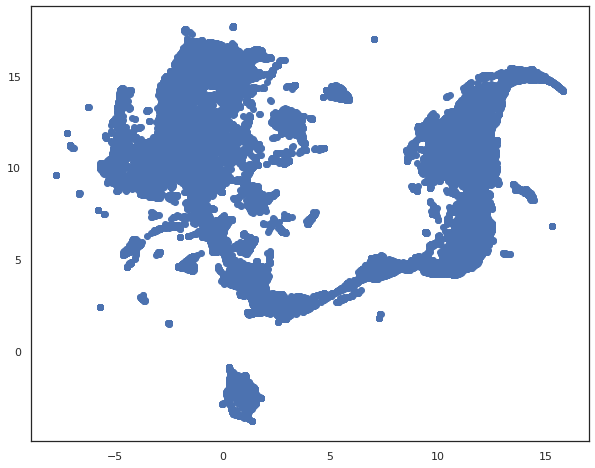

In [117]:
plt.scatter(standard_embedding[:,0], standard_embedding[:,1], cmap='Spectral')

In [ ]:
f = umap.plot.points(standard_embedding, labels=de_iab_list)

In [ ]:
bp = Babyplot(background_color="#ffffddff", turntable=True)
bp.add_plot(standard_embedding.tolist(), "pointCloud", "categories", {"colorScale": "Dark2"}
print(bp)

### K means clustering

In [118]:
from sklearn.cluster import KMeans

**This is K-means clustering with the dimension reduction using umap
i.e. dimension reduced to 2 by Umap and labels to the cluster by k-means**

**Features from keywords**

In [122]:
kmeans_labels = KMeans(n_clusters=29).fit_predict(test)

In [123]:
kmeans_labels

array([22,  0, 18, ..., 22,  7, 12], dtype=int32)

In [223]:
plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], c=kmeans_labels, s=0.1, cmap='Spectral')
plt.title("Clustering with Keywords embeddings")

Text(0.5, 1.0, 'Clustering with Keywords embeddings')

In [273]:
keyword_emb_df = pd.read_csv('/home/sanika/projects/iab_labelling/data/keyword_emb_df.csv')

In [274]:
keyword_emb_df.shape

(41713, 2)

In [275]:
keyword_emb_df['kmean labels'] = kmeans_labels

In [280]:
keyword_emb_df.loc[keyword_emb_df['kmean labels'] == 22]

keywords  \
0      Reise,Fernweh,USA-Reisen,Hawaii,Surfen,Aktiv r...   
13     Reise,Europa,Outdoor-Reisen,Norwegen-Reisen,Eu...   
96     Panorama,Justiz,Anschlag in Christchurch,Neuse...   
140    Netzwelt,Netzpolitik,Yahoo,Volksrepublik China...   
167    Panorama,Justiz,Nordrhein-Westfalen,Kleve,Poli...   
181    Wirtschaft,Unternehmen & Märkte,Volkswagen,Nie...   
188    Ausland,Attentat in Charleston 2015,Rassismus,...   
225    Kultur,TV,Rezensionen,Televisionen,Filme und S...   
227    Ausland,Schiiten,Jemen,Iran,Saudi-Arabien,Konf...   
231    Reise,Deutschland,Bücher rund ums Reisen,Deuts...   
272    Ausland,Rodrigo Duterte,Philippinen,Menschenre...   
318    Wirtschaft,Verbraucher & Service,Tenhagens Fin...   
324    Panorama,Gesellschaft,Spanien,Glücksspiel,Madr...   
376    Ausland,Barack Obama,Die Regierung Obama,Secre...   
378    Wissenschaft,Technik,Higgs-Boson,Physik,Teilch...   
379    Wirtschaft,Staat & Soziales,Steuern,Steuerbela...   
426    Politik,Deutschland,Die Linke,Opposition in Ch...   
433    Panorama,Justiz,Was wurde aus...?,G20-Gipfel i...   
453    Kultur,TV,TV-Serien,Filme und Serien,US-Fernse...   
485    Reise,Fernweh,Australien-Reisen,Australien,Rei...   
496    Panorama,Justiz,Moderne Piraten,Oman,Somalia,P...   
509    Panorama,Justiz,Köln,Nordrhein-Westfalen,Recht...   
510    Panorama,Gesellschaft,Rheinland-Pfalz,National...   
513    Wirtschaft,Unternehmen & Märkte,Foxconn,Apple,...   
547    Politik,Deutschland,Flüchtlinge,Asylrecht in D...   
556    Psychologie,Burn-out-Syndrom,Depressionen,Burn...   
564    Reise,Europa,Europa-Reisen,Balkan-Reisen,Reise...   
603    Wirtschaft,Staat & Soziales,G20-Gipfel in Hamb...   
610    Panorama,Justiz,Frauenrechte,Indien,Neu-Delhi,...   
638    Panorama,Justiz,Sexualdelikte,Hamburg,Sexualst...   
656    Job & Karriere,Seefahrt,Schifffahrt,Ein Schiff...   
666    Gesundheit,Ernährung & Fitness,Übergewicht,Abn...   
690    Wissenschaft,Mensch,Klimakrise,USA,Indianer,Lo...   
707    Job & Karriere,Spaß im Büro,Büroleben,Büromöbe...   
716    Panorama,GroKo-Sondierung 2017/2018,SPD,CDU,CS...   
720    Panorama,Justiz,Sexualdelikte,Mönchengladbach,...   
821    Wissenschaft,Mensch,Nobelpreise,Genforschung,F...   
835    Job & Karriere,MBA,Karriere,Manager von morgen...   
847    Wirtschaft,Staat & Soziales,Europäische Union,...   
903    Kultur,TV,Dschungelcamp,RTL,Privatfernsehen,Re...   
915    Kultur,TV,TV-Serien,Netflix,Televisionen,Filme...   
935    Panorama,Nordrhein-Westfalen,Bandidos,Hells An...   
940    Reise,Deutschland,Abgetaucht,Aktiv reisen,Deut...   
993    Mobilität,Stadt Essen,Pariser Autosalon,Genfer...   
994    Panorama,Justiz,Dresden,Kunstraub,Kunstdiebstä...   
1005   Kultur,Kino,Berlinale 2016,Kino,Neue Filme und...   
1037   Ausland,Kamerun,Frankreich,Paul Biya,Ukraineko...   
1048   Geschichte,Weltkriege,Waffen,Panzer,Erster Wel...   
1054   Kultur,TV,»Tatort«,Televisionen,Rezensionen,AR...   
1066   Wissenschaft,Mensch,Altes Ägypten,Ägypten,Tuta...   
1069   Netzwelt,Gadgets,iPod,MP3-Player,Apple,Steve J...   
1076   Wirtschaft,Verbraucher & Service,Warteschleife...   
1078   Panorama,Leute,Boris Johnson,Theresa May,Großb...   
1094   Mobilität,Mobilität von morgen,Pariser Autosal...   
1100   Panorama,Justiz,Übergriffe in Köln,Köln,Kölner...   
1149              Netzwelt,Gadgets,Amazon Echo,Netzwerke   
1181            Netzwelt,Angefasst,Rezensionen,Notebooks   
1224   Sport,Fußball-News,Fußball-Bundesliga,Borussia...   
1225   Geschichte,Rätsel und Geheimnisse,Kosmologie,e...   
1228   Wirtschaft,Unternehmen & Märkte,Georg Fahrensc...   
1273   Reise,Städtereisen,Israel-Reisen,Reiseziele,Na...   
1296   Sport,Fußball-News,Champions League,Bayern Mün...   
1299   Politik,Deutschland,NPD,Saarland,Rechtsextremi...   
1306   Ausland,Osama Bin Laden,Pakistan,Al-Qaida,Isla...   
1363   Panorama,Leute,Früherkennung,Krebs,Brustkrebs,...   
1369   Ausland,Flüchtlinge,Donald Trump,Demokraten (U...   
1386   Sport,Fußball-News,Ch

In [282]:
keyword_emb_df.groupby(keyword_emb_df['kmean labels']).agg({'keywords': set})

keywords
kmean labels                                                   
0             {nan, Reise,Abu Dhabi,Freizeitparks,Ferrari, K...
1             {Ausland,Saudi-Arabien,König Salman von Saudi-...
2             {Ausland,Großbritannien,Brexit,Ukip,Europäisch...
3             {Sport,Fußball-News,Fußball-Bundesliga,Mainz 0...
4             {Politik,Deutschland,G-8-Gipfel in Heiligendam...
5             {Panorama,Flüchtlinge,Griechenland,Bamf (Bunde...
6             {Panorama,Justiz,Einbrüche in Deutschland,Nord...
7             {Ausland,Donald Trump,Kim Jong Un,Atomkonflikt...
8             {Netzwelt,Gadgets,Smartphones,Android,Kenia,Ha...
9             {Geschichte,Von Helden und Lebenskünstlern,196...
10            {Kultur,Kino,Neue Filme und Serien,Kino,Durchg...
11            {Mobilität,Dieselaffäre,Diesel-Fahrverbote,Abg...
12            {Gesundheit,Diagnose & Therapie,Meinung,Leben,...
13            {Ausland,Marine Le Pen,Front National,Wladimir...
14            {Wirtschaft,Staat & Soziales,Donald Trump,Wirt...
15            {Sport,Fußball-News,Fußball-Bundesliga,Hertha ...
16            {Gesundheit,Diagnose & Therapie,Ein rätselhaft...
17            {Mobilität,Volvo-Modelle,Diesel,Elektroautos,D...
18            {Gesundheit,Diagnose & Therapie,Allergien,Bakt...
19            {Netzwelt,Netzpolitik,Hacker,Drohnen,Navigatio...
20            {Gesundheit,Schwangerschaft & Kind,Kindergesun...
21            {Wirtschaft,Staat & Soziales,Handelsstreit mit...
22            {Sport,Fußball-News,Fußball-WM 2014,Fußballnat...
23            {Kultur,TV,»Maischberger«-Talkshow,Sandra Mais...
24            {Ausland,Mohammed bin Salman,USA,Jamal Khashog...
25            {Panorama,Justiz,KZ Auschwitz,Kriegsverbrechen...
26            {Wirtschaft,Unternehmen & Märkte,USA,Wirtschaf...
27            {Panorama,Leute,Sandra Bullock,George Clooney,...
28            {Panorama,Justiz,Todesstrafe,USA,Florida,Oklah...

In [270]:
keyword_emb_df['kmean labels']

(41713,)

**Features from description**

In [196]:
desc_feat = pd.read_csv('/home/sanika/projects/iab_labelling/data/desc_emb_df.csv')

In [206]:
desc_feat

description  \
0      Sie ist 62 und hat am frühen Morgen nur eins i...   
1      Deutschlands führende Nachrichtenseite. Alles ...   
2      Pinguine mit Stein-Tick, Eisberge in Herzform ...   
3      Häufig trifft es Sportler oder Menschen, die i...   
4      Ihre Karriere begann mit einer Ohrfeige ­ jetz...   
...                                                  ...   
17977  Die neue Jahreszahl 2017 eignet sich perfekt f...   
17978  Bei der Castingshow "Deutschland sucht den Sup...   
17979  Sich so richtig abstrampeln und dabei besser l...   
17980  "Das Grundgesetz sieht Enteignungen zum Allgem...   
17981  Der AfD-Politiker Volker Münz hat bei einer Ge...   

                                              embeddings  
0      [0.28091636300086975, -0.22308261692523956, 0....  
1      [0.23463387787342072, -0.040582381188869476, 0...  
2      [0.2793578803539276, -0.23093914985656738, 0.3...  
3      [0.22333066165447235, -0.18848316371440887, 0....  
4      [0.1961936205625534, -0.14697112143039703, 0.3...  
...                                                  ...  
17977  [-0.10459127277135849, 0.05190953239798546, 0....  
17978  [0.3220917582511902, -0.1895257830619812, 0.41...  
17979  [0.0034004617482423782, -0.24307256937026978, ...  
17980  [0.10764130204916, -0.23497465252876282, 0.244...  
17981  [0.24936194717884064, -0.24278438091278076, 0....  

[17982 rows x 2 columns]

In [213]:
desc_feat['embeddings'] = desc_feat['embeddings'].apply(literal_eval)

In [215]:
desc_feat_df = pd.DataFrame([list(desc_feat['embeddings'][i][:]) for i in desc_feat.index])

In [216]:
desc_feat_df

0         1         2         3         4         5         6  \
0      0.280916 -0.223083  0.399677 -0.369901 -0.152307  0.435036  0.273039   
1      0.234634 -0.040582  0.300791 -0.349889 -0.154157  0.396273  0.252172   
2      0.279358 -0.230939  0.374888 -0.364120 -0.122499  0.426898  0.235819   
3      0.223331 -0.188483  0.343465 -0.275180 -0.063796  0.307596  0.219674   
4      0.196194 -0.146971  0.386602 -0.400877 -0.212845  0.423546  0.342154   
...         ...       ...       ...       ...       ...       ...       ...   
17977 -0.104591  0.051910  0.145301  0.186962 -0.095722  0.026439  0.262126   
17978  0.322092 -0.189526  0.416037 -0.369638 -0.150104  0.439324  0.271017   
17979  0.003400 -0.243073  0.283819 -0.448040 -0.491864  0.271878  0.424260   
17980  0.107641 -0.234975  0.244315 -0.522857 -0.499773  0.239392  0.485661   
17981  0.249362 -0.242784  0.357205 -0.325913 -0.114895  0.348605  0.257309   

              7         8         9        10        11        12        13  \
0      0.282215 -0.470564  0.199746 -0.085340 -0.236558 -0.092204 -0.176514   
1      0.324492 -0.475646  0.301852 -0.072668 -0.310102  0.023310 -0.278394   
2      0.269235 -0.419817  0.215345 -0.065554 -0.195533 -0.089598 -0.193284   
3      0.239447 -0.410373  0.156767  0.002320 -0.186059 -0.054913 -0.193470   
4      0.245907 -0.473964  0.183310 -0.122790 -0.338041 -0.003734 -0.290824   
...         ...       ...       ...       ...       ...       ...       ...   
17977  0.178331 -0.295363 -0.043142  0.200804 -0.085822  0.162232 -0.152413   
17978  0.275882 -0.511243  0.213895 -0.062713 -0.260902 -0.109903 -0.212800   
17979  0.163070 -0.239446  0.012785 -0.068061 -0.162138 -0.015346 -0.337612   
17980  0.199376 -0.326179 -0.007598 -0.143097 -0.091299  0.005570 -0.394919   
17981  0.260718 -0.458663  0.188152 -0.019923 -0.200182 -0.082392 -0.193701   

             14        15        16        17        18        19        20  \
0      0.166441 -0.198027  0.691751  0.180579  0.193303 -0.300428 -0.999988   
1      0.231418 -0.466094  0.696218  0.311059  0.151669 -0.484295 -0.999983   
2      0.121484 -0.215401  0.722779  0.187323  0.178328 -0.302956 -0.999988   
3      0.122496 -0.102575  0.578270  0.114031  0.124766 -0.233126 -0.999947   
4      0.214419 -0.300735  0.652052  0.349064  0.281414 -0.352906 -0.999892   
...         ...       ...       ...       ...       ...       ...       ...   
17977 -0.109858 -0.161111  0.117112  0.176445  0.095301  0.094604 -0.966277   
17978  0.182263 -0.245088  0.713157  0.187907  0.212399 -0.302154 -0.999990   
17979  0.279089 -0.248238  0.216978  0.367995  0.417575  0.162567 -0.929593   
17980  0.258291 -0.239100  0.211310  0.404373  0.393701  0.048629 -0.932875   
17981  0.117103 -0.164028  0.614306  0.166718  0.192133 -0.227847 -0.999970   

             21        22        23        24        25        26        27  \
0     -0.189705 -0.356375 -0.132533 -0.478752  0.208265 -0.149999  0.260924   
1     -0.104033 -0.427788 -0.160720 -0.422409  0.113540 -0.092345  0.226041   
2     -0.164846 -0.344793 -0.123044 -0.522415  0.202776 -0.138162  0.256083   
3     -0.122121 -0.204868 -0.114688 -0.444425  0.182085 -0.092417  0.244579   
4     -0.124758 -0.408258 -0.186089 -0.359303  0.099553 -0.109125  0.305813   
...         ...       ...       ...       ...       ...       ...       ...   
17977  0.001431  0.068118 -0.053212 -0.210603 -0.107040  0.085388  0.314202   
17978 -0.188653 -0.382028 -0.104934 -0.527475  0.174299 -0.161919  0.267628   
17979 -0.136112 -0.121049 -0.284716 -0.522095  0.204254 -0.169675  0.403522   
17980 -0.296732 -0.150934 -0.283966 -0.572181  0.224767 -0.239647  0.431617   
17981 -0.161425 -0.311445 -0.110918 -0.471922  0.174561 -0.117144  0.280468   

             28        29        30        31        32        33        34  \
0      0.143288 -0.175929  0.147658 -0.999989  0.649197  0.580714  0.130951   
1      0.179630 -0.106623 -0.153579 -0.999978  0.754109  0.6

In [217]:
kmeans_labels_desc = KMeans(n_clusters=29).fit_predict(desc_feat_df)

In [253]:
standard_embedding_desc = umap.UMAP(n_neighbors=5, min_dist=0, n_components=3, metric = 'cosine').fit_transform(desc_feat_df)

In [254]:
standard_embedding_desc.shape

(17982, 3)

Text(0.5, 1.0, 'Clustering with Description embeddings')

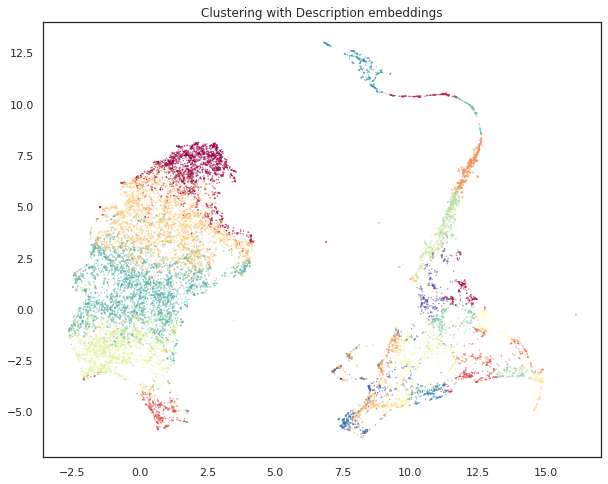

In [235]:
plt.scatter(standard_embedding_desc[:, 0], standard_embedding_desc[:, 1], c=kmeans_labels_desc, s=0.1, cmap='Spectral')
plt.title("Clustering with Description embeddings")

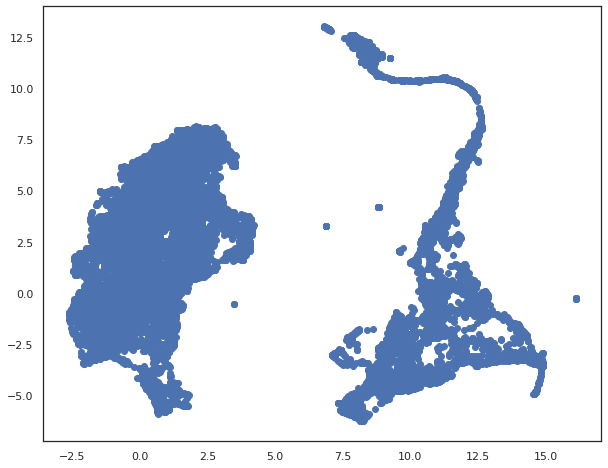

In [236]:
plt.scatter(standard_embedding_desc[:,0], standard_embedding_desc[:,1], cmap='Spectral')

In [246]:
from mpl_toolkits.mplot3d import Axes3D

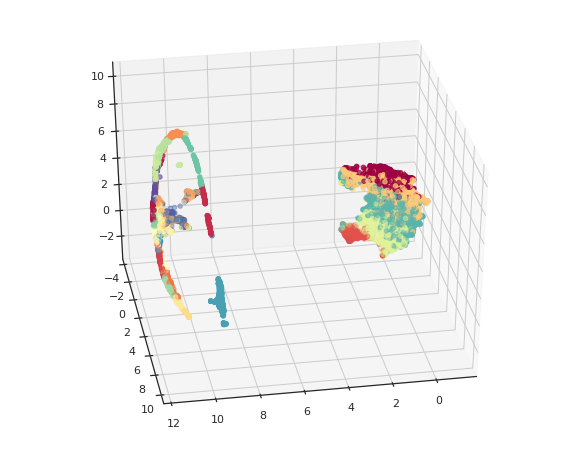

In [255]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(standard_embedding_desc[:,0], standard_embedding_desc[:,1], standard_embedding_desc[:,2], c=kmeans_labels_desc, cmap='Spectral')
ax.view_init(35, 80)

In [256]:
kmeans_labels_desc

array([10, 26,  0, ..., 18, 18, 23], dtype=int32)

In [259]:
desc_feat['kmean cluster label'] = kmeans_labels_desc

In [262]:
desc_feat

description  \
0      Sie ist 62 und hat am frühen Morgen nur eins i...   
1      Deutschlands führende Nachrichtenseite. Alles ...   
2      Pinguine mit Stein-Tick, Eisberge in Herzform ...   
3      Häufig trifft es Sportler oder Menschen, die i...   
4      Ihre Karriere begann mit einer Ohrfeige ­ jetz...   
...                                                  ...   
17977  Die neue Jahreszahl 2017 eignet sich perfekt f...   
17978  Bei der Castingshow "Deutschland sucht den Sup...   
17979  Sich so richtig abstrampeln und dabei besser l...   
17980  "Das Grundgesetz sieht Enteignungen zum Allgem...   
17981  Der AfD-Politiker Volker Münz hat bei einer Ge...   

                                              embeddings  kmean cluster label  
0      [0.28091636300086975, -0.22308261692523956, 0....                   10  
1      [0.23463387787342072, -0.040582381188869476, 0...                   26  
2      [0.2793578803539276, -0.23093914985656738, 0.3...                    0  
3      [0.22333066165447235, -0.18848316371440887, 0....                   17  
4      [0.1961936205625534, -0.14697112143039703, 0.3...                   26  
...                                                  ...                  ...  
17977  [-0.10459127277135849, 0.05190953239798546, 0....                   14  
17978  [0.3220917582511902, -0.1895257830619812, 0.41...                    0  
17979  [0.0034004617482423782, -0.24307256937026978, ...                   18  
17980  [0.10764130204916, -0.23497465252876282, 0.244...                   18  
17981  [0.24936194717884064, -0.24278438091278076, 0....                   23  

[17982 rows x 3 columns]